# Abigail Kahler
## Homework 13: Graded Code Submission 2

## Grade
Great work! I'm glad to see its all coming together. I left you a few general tips here and some comments throughout. 

Tips for future improvment: 
- Definte your functions in a separate script and just source them in the notebook 
- Move all of your user inputs/variables to the top in a single block of code. 
- If you are not using any additional datsets in your forecast you don't need to include them here. You should try to make this notebook as short as possible so that a user can pick it up and re-create your results. 


### 1. Purpose
This notebook generates a one and two week forecast, a 16 week forecast, two types of plots justifying data adjustments, and a multilayerd map identifying the river of interest. This has been a cumulative effort throughout the semester,
with a purpose of building the skills to compile multiple datasets to ultimately produce a more accurate long-range
forecast.

### 2. Forecasts
All of the forecasts are generated from an autoregression model based on streamgage data in log form. As will be illustrated below, manipulating the data in this way presented a near normal distribution, which allows for a better fit in the model. I built the model on the years 2017 and 2018 because, though 2019 was a recent dry year comparable to 2020, this selection gave the model a slightly better coefficient of determination.

The 16 week forecast is organized into four loops; each containing four weeks. The AR model predictions did not fully represent seasonal trends, so I added an adjustment factor into each loop to account for this. As it is now, the starting values of the 16 week forecast are much higher than the measured values, but I am trying to exclude knowledge of the values we have now and stay true to August 21, 2020 being the last date to be used for analysis. 


### 3. Progress
At times it has been a struggle to keep up, but I am noticing that new tasks are not as intimidating as they were at the start of the semester. A lot of my work has been just getting by, but I am confident that it has built a foundation that can be revisited and solidified over winter break. My forecast has evolved from the initial guessing to relying on streamflow and exploring flow criteria by year, season, or month, and experimenting with data manipulations and combination with other datasets. No other datasets are included in my model at this time, as I found that air temperature did not significantly affect the result, and adding 2020 precipitation up to August would not greatly support the 16 week forecast.

In [1]:
import pandas as pd
import numpy as np
import os as os
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
from sklearn.linear_model import LinearRegression
import contextily as ctx

### Download Net CDF historical time series for use in temperature plot
#### https://towardsdatascience.com/handling-netcdf-files-using-xarray-for-absolute-beginners-111a8ab4463f
### Download Gauges II USGS streamgage dataset for mapping
#### https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml 
### Download USA Rivers and Streams dataset for mapping
#### https://hub.arcgis.com/datasets/esri::usa-rivers-and-streams/data?geometry=-126.415%2C30.380%2C-96.906%2C36.781&page=3

### Functions for generating forecast and histogram

In [2]:
def single_forecast(model, x):
    """Function performing the forecast calculation, where
        model = model used to generate prediction
            (must be a log to log scale autoregression)
        x = starting value of streamflow, can be integer or float
            (input must be in natural log scale!)

        returns: a prediction
            (note the prediction is returned in natural log scale)
            (however, the result is printed in nonlog scale)
    """
    # makes a prediction (in log space)
    prediction = (model.intercept_ + model.coef_ * x)
    # prints a prediction (in arithmetic space)
    print('forecast value', np.exp(prediction).round(2))
    # returns prediction (in log space)
    return prediction


In [3]:
def hist(data_in):
    """This function generates two histograms based on the input of a dataset of
    streamflow stored in natural log format

    Abigail, put in train['flow']

    data_in = a series from a pandas dataframe
              containing streamflow data in log

    shows two histograms, one of the data represented in log space and
    the other represented in arithmetic space

    the purpose is to show how doing your autoregression with 'log' data helps
    to normalize the underlying data, and generate better fits to training data

    returns nothing

    """
    # Histogram of flow data in natural log space
    textstr1 = '\n'.join((
                        'The flow data have',
                        'a nearly normal distribution',
                        'in log space'))
    fig, ax = plt.subplots()
    ax.hist(data_in, bins=10)
    ax.set(xlabel='flow in natural log scale',
           ylabel='frequency', ylim=(0, 100))
    ax.text(0.4, 0.95, textstr1, transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
    plt.show()

    # Histogram of flow data in natural log space
    textstr2 = '\n'.join((
                        'The flow data have',
                        'a very skewed distribution',
                        'in arithmetic space'))
    fig, ax = plt.subplots()
    ax.hist(np.exp(data_in), bins=10)
    ax.set(xlabel='flow in arithmetic scale',
           ylabel='frequency', ylim=(0, 100))
    ax.text(0.4, 0.95, textstr2, transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
    plt.show()

In [4]:
# Accessing the downloaded Net CDF historical reanalysis temperature time series
data_path = os.path.join('../data',
                         'tempdailyave_NECP.nc')
# Read in the dataset as an x-array
dataset = xr.open_dataset(data_path)

### Define temperature values at one spacial point

In [5]:
airtemp = dataset['air']

lat = dataset["air"]["lat"].values[0]
lon = dataset["air"]["lon"].values[0]
time = dataset['air']['time'].values[0]
print("Long, Lat values:", lon, lat)
first_point = dataset["air"].sel(lat=lat,lon=lon)
year_2019 = first_point.head(362)


Long, Lat values: 247.5 35.0


### Access streamflow data directly from USGS website and convert to dataframe

In [6]:
# Input start and end dates
# LC - These 3 could be variables at the top of your script. 
site = '09506000'
start = '1990-01-01'
# Last date available for 16 week forecast
end = '2020-08-21'

url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" + \
      site + "&referred_module=sw&period=&begin_date=" + start + \
      "&end_date=" + end
data = pd.read_table(url, skiprows=30, names=['agency_cd', 'site_no',
                                              'datetime', 'flow', 'code'],
                     parse_dates=['datetime'])

data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).dayofweek
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

# Aggregate flow values to weekly
flow_weekly = data.resample("W", on='datetime').mean()

# Set flow_weekly to natural log
flow_weekly_log = np.log(flow_weekly)
flow_weekly_log['flow_tm1'] = flow_weekly_log['flow'].shift(1)

### Select years for training and fit the model

In [7]:
train = flow_weekly_log['2017-01-01':'2019-01-01'][['flow', 'flow_tm1']]# theset dates could be variables you set at the top
model = LinearRegression()
x = train['flow_tm1'].values.reshape(-1, 1)
y = train['flow'].values
model.fit(x, y)

r_sq = model.score(x, y)
print('coefficient of determination:', np.round(r_sq, 2))

coefficient of determination: 0.87


### This 2019 temperature plot provides an example of a datatype that naturally follows a near-normal distribution. While temperature does have seasonal patterns, the extremes build slowly and have a generally single peak. Streamflow also has seasonal patterns, but the sudden accumlutation of streamflow causes values to rise dramatically and create many peaks.

[Text(0.5, 1.0, '2019 Air Temp. Distribution for Single Lat / Lon Location')]

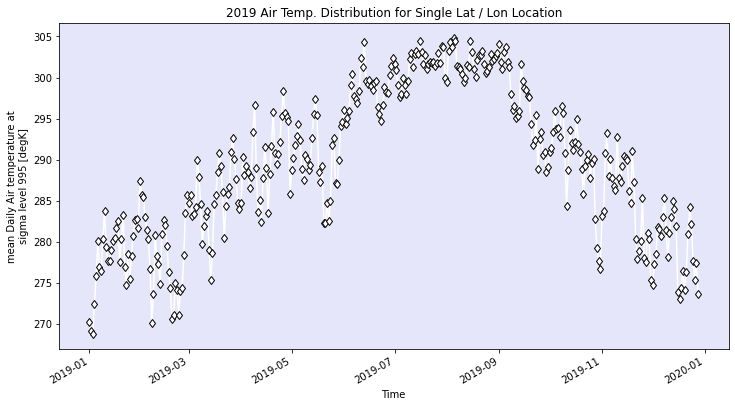

In [8]:
# Timeseries plot of 2019 temperature distribution
f, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('lavender')
year_2019.plot.line(hue='lat',
                    marker="d",
                    ax=ax,
                    color="white",
                    markerfacecolor="white",
                    markeredgecolor="black")
ax.set(title="2019 Air Temp. Distribution for Single Lat / Lon Location")

### The distribution of the raw streamflow data was not suited to model analysis. Converting to log form decreases the variability of the data caused by seasonal extremes. This may need to be revisited for plotting multiple time series together. Adding a normalization transormation on top of this could stray too far from representative.

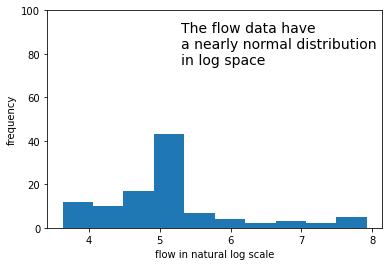

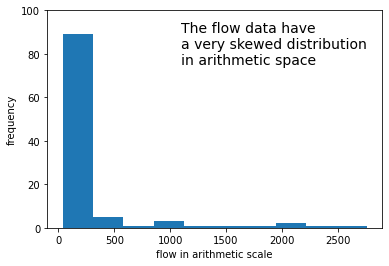

In [9]:
hist(train['flow'])

### Generating AR model for one and two week forecast

In [10]:
# Starting value
start_val = flow_weekly.flow[-3]

# starting value in natural log (needed for regression)
start_val_ln = np.log(start_val)

# create two week forecast (saved in natural log)
adjust = 1.05
print('one week')
first_forecast = single_forecast(model, start_val_ln*adjust)
print('two week')
second_forecast = single_forecast(model, first_forecast*adjust)


one week
forecast value [55.98]
two week
forecast value [72.97]


### Generating 16 week forecast by setting a unique scaling factor for each four week increment

In [11]:
#LC - THis part is a little hard for me to follow some comments throughout and a more detailed  descirption would be good. 
adjust = 1.0 
sixteen_week_forecast = np.zeros(4)
for i in range(4):
    print('week',i+1)
    sixteen_week_forecast[i] = single_forecast(model, first_forecast * adjust)
    first_forecast = sixteen_week_forecast[i]
adjust = 1.01
sixteen_week_forecast2 = np.zeros(4)
for i in range(4):
    print('week',i+5)
    sixteen_week_forecast2[i] = single_forecast(model, first_forecast * adjust)
    first_forecast = sixteen_week_forecast2[i]
adjust = 1.03
sixteen_week_forecast3 = np.zeros(4)
for i in range(4):
    print('week',i+9)
    sixteen_week_forecast3[i] = single_forecast(model, first_forecast * adjust)
    first_forecast = sixteen_week_forecast3[i]
adjust = 1.02
sixteen_week_forecast4 = np.zeros(4)
for i in range(4):
    print('week',i+13)
    sixteen_week_forecast4[i] = single_forecast(model, first_forecast * adjust)
    first_forecast = sixteen_week_forecast4[i]

week 1
forecast value [60.81]
week 2
forecast value [65.55]
week 3
forecast value [70.16]
week 4
forecast value [74.62]
week 5
forecast value [82.05]
week 6
forecast value [89.49]
week 7
forecast value [96.88]
week 8
forecast value [104.18]
week 9
forecast value [121.12]
week 10
forecast value [139.4]
week 11
forecast value [158.93]
week 12
forecast value [179.61]
week 13
forecast value [192.09]
week 14
forecast value [204.38]
week 15
forecast value [216.44]
week 16
forecast value [228.21]


In [12]:
# LC  - Could use a MD intro to this seciton noting that you are making a map now. 
# Reading in the downloaded Gages II shapefile with geopandas
# LC - Also good practice to put all of the inputfile reads at the very top in a separate block. 
file = os.path.join('..\data', 'gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)

# Reading in the downloaded USA Rivers and Streams shapefile with geopandas
file = os.path.join('..\data', '9ae73184-d43c-4ab8-940a-'\
    'c8687f61952f2020328-1-r9gw71.0odx9.shp')
usarivers = gpd.read_file(file)

In [13]:
# Select AZ streamgages, rivers, and the Verde River
gages_AZ=gages[gages['STATE']=='AZ']
azrivers = usarivers[usarivers['State']=='AZ']
verde = azrivers.loc[azrivers.Name=='Verde River']

# Reproject all layers to match gages crs
reproject_verde = verde.to_crs(gages.crs)
reproject_azrivers = azrivers.to_crs(gages.crs)

### This map is intended to be a tool for communicating with non-specialists; perhaps in an educational outreach program. It communicates the extent of rivers in streams in Arizona, which people outside of the state generalize as being consistently dry. While some of these streams are only seasonal, their existence is crucial to supporting ecosystems through seasonal cycles. For this project, the Verde River is highlighted within the big picture of all streams and gages. This overview can give insight into what other gages might be beneficial to include in the Verde streamflow forecast.

### The map image can be accessed in the submissions file under the name kahler_hw13_map.png

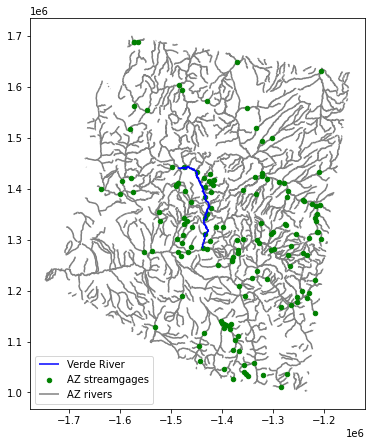

In [14]:
# Map featuring the Verde River within the context of AZ rivers and gages
fig, ax =plt.subplots(figsize=(6,8))
reproject_verde.plot(ax=ax, color = 'b', zorder = 3, label = 'Verde River')
gages_AZ.plot(markersize=20, c = 'g', zorder = 2,
              ax=ax, label = 'AZ streamgages')
reproject_azrivers.plot(ax=ax, color = 'gray', zorder = 1, label = 'AZ rivers')
ax.legend()
plt.show()